<a href="https://colab.research.google.com/github/intel-analytics/Chronos-workshop/blob/main/notebook/chronos_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

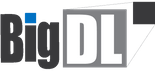

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[pytorch,distributed]`.

- We use pytorch as backend here, while chronos also support tensorflow as well.
- This may take 3-5min according to the network condition, google colab has a pre-defined environment which makes the installation more complex.
- This block is designed to exit(crash) for refreshing installed pkg. If you see something like `"Your session crashed for an unknown reason."` then your installation is succeeded.

You may refer to [here](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Overview/chronos.html#install) for detailed installation information.

In [ ]:
print("This block is designed to exit(crash) for refreshing installed pkg.")

# Install latest pre-release version of bigdl-chronos
!pip install --pre --upgrade bigdl-chronos[pytorch]

# acclerators
!pip install onnx
!pip install onnxruntime
!pip install openvino-dev

# for quantization
!pip install neural-compressor==1.11

# fix confict with google colab
!pip uninstall -y torchtext
!pip install numpy==1.21
!pip install opencv-python-headless==4.1.2.30

# restart the runtime to refresh installed pkg
exit()

### Step 0: Prepare dataset
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [ ]:
from bigdl.chronos.data.repo_dataset import get_public_dataset

tsdata_train, tsdata_valid, tsdata_test = get_public_dataset("nyc_taxi")

## **Time series forecasting using Chronos Forecaster**

### Forecaster Step1. Data transformation and feature engineering using Chronos TSDataset 
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

Preprocess the datasets. Here we perform:
- deduplicate: remove those identical data records
- impute: fill the missing values
- gen_dt_feature: generate feature from datetime (e.g. month, day...)
- scale: scale each feature to standard distribution.
- roll: sample the data with sliding window.

For forecasting task, we will look back 3 hours' historical data (6 records) and predict the value of next 30 miniutes (1 records).

We perform the same transformation processes on train, valid and test set.

In [ ]:
from sklearn.preprocessing import StandardScaler

past_seq_len, future_seq_len = 96, 1

scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
    tsdata.impute()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=past_seq_len, horizon=future_seq_len)

### Forecaster Step 2: Time series forecasting using Chronos Forecaster
After preprocessing the datasets. We can use [Chronos Forecaster](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html) to handle the forecasting tasks.

In [ ]:
from bigdl.chronos.forecaster import TCNForecaster

forecaster = TCNForecaster.from_tsdataset(tsdata_train, num_channels=[16]*3)
forecaster.fit(tsdata_train)

### Forecaster Step 3: Evaluate your fitted forecaster
Use fitted forecaster to predict test data and plot the result

In [ ]:
x_test, y_test = tsdata_test.to_numpy()
pred = forecaster.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.plot(pred_unscale[:,:,0])
plt.plot(groundtruth_unscale[:,:,0])
plt.legend(["prediction", "ground truth"])

### Forecaster Step 4: Further Optimize my forecaster

#### Use some accelerators for inferencing

Accelerate my forecaster! That's a normal request from many of our customers. One way to do this is to adopt some accelerator such as:

- onnxruntime: an accelerator provided by Microsoft on onnx structure.
- openvino: an inference engine provided by Intel

Adopting them in Chronos is super easy, just call `predict_with_onnx` and `predict_with_openvino`, the forecaster abstraction will hide all the complex calling for our users.

In [ ]:
pred_onnxruntime = forecaster.predict_with_onnx(x_test)
pred_openvino = forecaster.predict_with_openvino(x_test)

In [ ]:
from bigdl.chronos.metric.forecast_metrics import Evaluator

def func_original():
    forecaster.predict(x_test[0:1, :, :])
def func_onnxruntime():
    forecaster.predict_with_onnx(x_test[0:1, :, :])
def func_openvino():
    forecaster.predict_with_openvino(x_test[0:1, :, :])

print("original pytorch runtime (ms):", Evaluator.get_latency(func_original))
print("use accelerator (onnxruntime) (ms):", Evaluator.get_latency(func_onnxruntime))
print("use accelerator (openvino) (ms):", Evaluator.get_latency(func_openvino))

#### Quantize my forecaster

Quantization has become more and more important in model serving and edge environment, since it can help you

- improve inference throughput and latency
- shrink the forecaster's size

In Chronos forecaster, `forecaster.quantize` will call Intel Neural Compressor and hide the complex setting to our users.

In [ ]:
forecaster.quantize(tsdata_train.to_numpy())

### Forecaster Step 5: Save my forecaster

You may save & restore the (non-quantized & quantized) forecaster.

In [ ]:
forecaster.save("nyc_taxi.fxt", "nyc_taxi_q.fxt")
forecaster.load("nyc_taxi.fxt", "nyc_taxi_q.fxt")